# Imports

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, roc_curve, confusion_matrix
from scipy import stats
from xgboost import XGBClassifier

Load the data

In [71]:
df1 = pd.read_csv("train.csv")
df2 = pd.read_csv("test.csv")

Inspect dataset shapes

In [72]:
df1.shape, df2.shape

((18524, 9), (6175, 8))

Check for missing values

In [73]:
df1.isnull().sum()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [74]:
df2.isnull().sum()

id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64

# Clean missing values

In [75]:
def clean_missing_value(df):
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if np.issubdtype(df[col].dtype, np.number):
                df[col] = df[col].fillna(df[col].mean())
            else:
                df[col] = df[col].fillna(df[col].mode()[0])
    return df

df1 = clean_missing_value(df1)
df2 = clean_missing_value(df2)


 # Encode


In [76]:
def encode_categorical_columns(df):
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col] = df[col].map({'No': 0, 'Yes': 1, 'Introvert': 0, 'Extrovert': 1})
    return df

df1 = encode_categorical_columns(df1)
df2 = encode_categorical_columns(df2)


# Feature Engineering

In [77]:
def feature_engineering(df):

    # Alone_to_Social_Ratio: Ratio of time spent alone to social event attendance
    # Introverts may spend more time alone compared to extroverts who attend more events"
    df['Alone_to_Social_Ratio'] = df['Time_spent_Alone'] / (df['Social_event_attendance'] + 1)

    # Energy_Drain_Index: Measure of energy drain after socializing
    # Introverts may experience higher energy drain after social events compared to extroverts"
    df['Energy_Drain_Index'] = df['Drained_after_socializing'] / (df['Social_event_attendance'] + 1)

    # Social_Activity_Score: Composite score of social activities
    # Extroverts are likely to have higher social activity scores due to more frequent social interactions
    df['Social_Activity_Score'] = df['Social_event_attendance'] + df['Going_outside'] + df['Post_frequency'] + df['Friends_circle_size']

    # Confidence_Index: Ratio of social event attendance to stage fear
    # Extroverts may have higher confidence in social settings, reflected in lower stage fear relative
    df['Confidence_Index'] = df['Social_event_attendance'] / (df['Stage_fear'] + 1)

    # Total_Engagement: Sum of various social engagement metrics
    # Extroverts are expected to have higher total engagement in social activities
    df['Total_Engagement'] = df['Social_event_attendance'] + df['Going_outside'] + df['Friends_circle_size'] + df['Post_frequency']
    
    return df

df1 = feature_engineering(df1)
df2 = feature_engineering(df2)


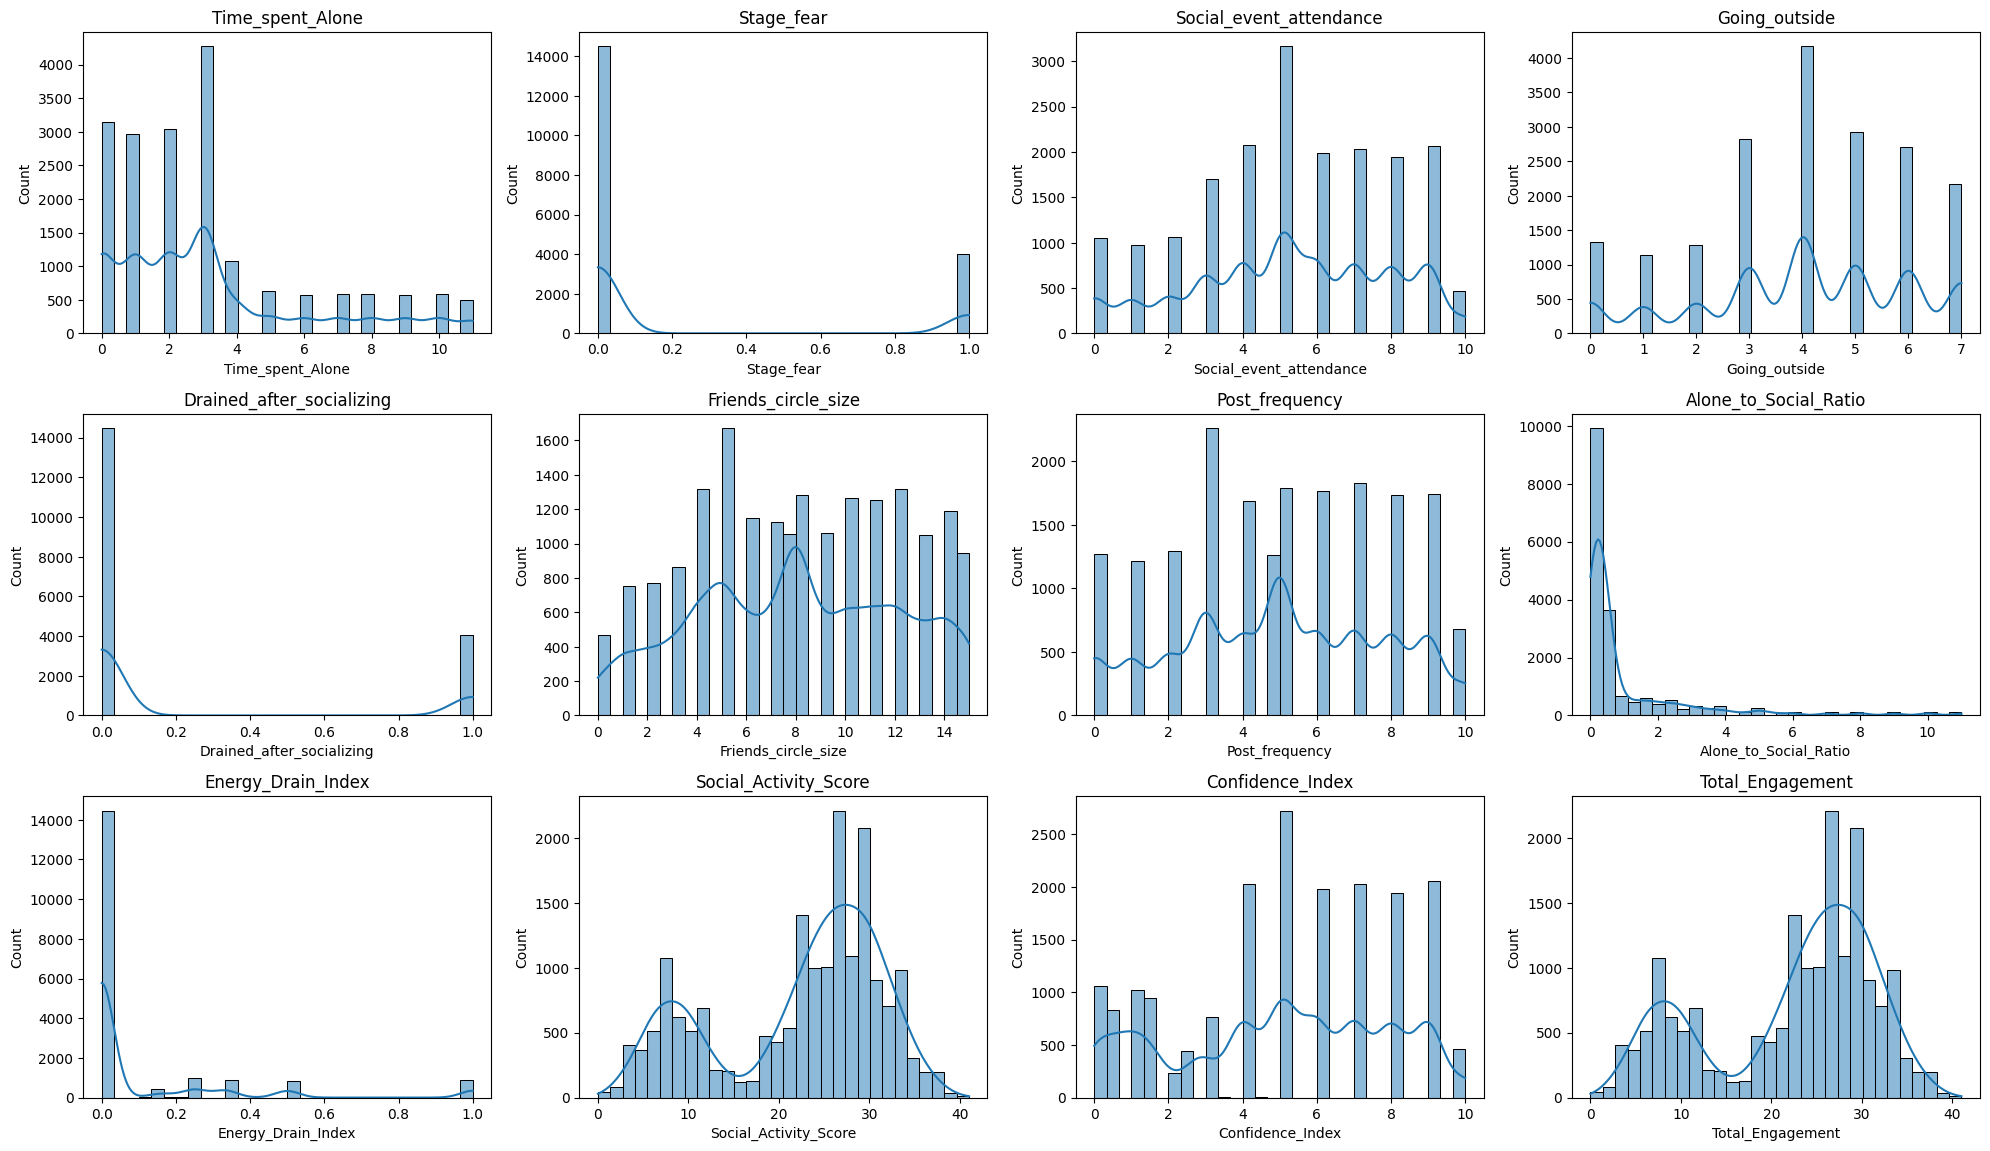

In [78]:
numeric_cols = df1.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['id','Personality']]

plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df1[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()


# Train-Test Split

In [79]:
X = df1.drop(['id', 'Personality'], axis=1)
y = df1['Personality']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Feature Scaling

In [80]:
numeric_cols = ['Time_spent_Alone', 'Social_event_attendance', 
                'Going_outside', 'Post_frequency', 'Friends_circle_size', 
                'Stage_fear', 'Drained_after_socializing',
                'Alone_to_Social_Ratio', 'Energy_Drain_Index', 
                'Social_Activity_Score', 'Confidence_Index', 'Total_Engagement']

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
df2[numeric_cols] = scaler.transform(df2[numeric_cols])


# Outlier Removal with Z-Score

In [81]:
from scipy import stats

X_full = X_train.copy()
numeric_cols_all = numeric_cols 

z_scores = np.abs(stats.zscore(X_full[numeric_cols_all], nan_policy='omit'))

mask = (z_scores < 3).all(axis=1)

X_train_clean = X_train[mask].reset_index(drop=True)
y_train_clean = y_train[mask].reset_index(drop=True)

print("Original X_train shape:", X_train.shape)
print("Cleaned X_train shape:", X_train_clean.shape)


Original X_train shape: (14819, 12)
Cleaned X_train shape: (14032, 12)


# Random Forest Model 

In [82]:
# We train a Random Forest classifier on the cleaned training data and evaluate it on the validation set.
 
X_train_clean = X_train[mask].reset_index(drop=True)
y_train_clean = y_train[mask].reset_index(drop=True)

# Train RandomForest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=2,
    random_state=42
)
rf.fit(X_train_clean, y_train_clean)
print("Random Forest model trained successfully!")

Random Forest model trained successfully!


Validation Predictions

In [83]:
# - **Accuracy**: Overall correctness  
# - **Precision**: True positives among predicted positives  
# - **Recall**: True positives among actual positives  
# - **F1 Score**: Balance between precision and recall  
# - **Log Loss**: Measures probability error  
# - **AUC**: Area under the ROC curve  
# - **Confusion Matrix**: Shows actual vs predicted labels

# Predictions
y_val_pred = rf.predict(X_val)
y_val_prob = rf.predict_proba(X_val)

# Calculate metrics
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred))
print("Log Loss:", log_loss(y_val, y_val_prob))
auc = roc_auc_score(y_val, y_val_prob[:,1])
print("AUC:", auc)

cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", cm)

Validation Accuracy: 0.968421052631579
Precision: 0.9765003615328995
Recall: 0.9811115147112242
F1 Score: 0.9788005073382859
Log Loss: 0.1333121807029172
AUC: 0.9663882716181278
Confusion Matrix:
 [[ 887   65]
 [  52 2701]]


Random Forest Model Visualization

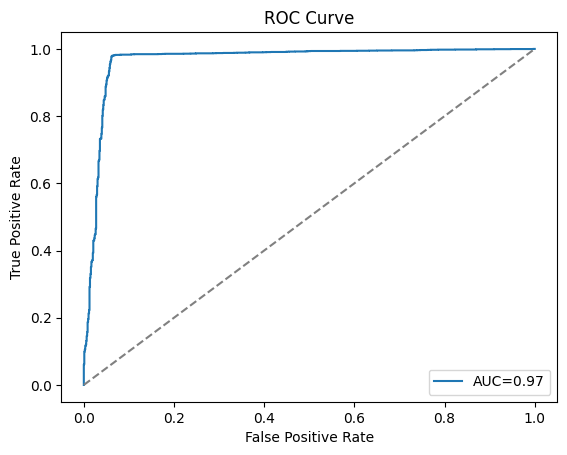

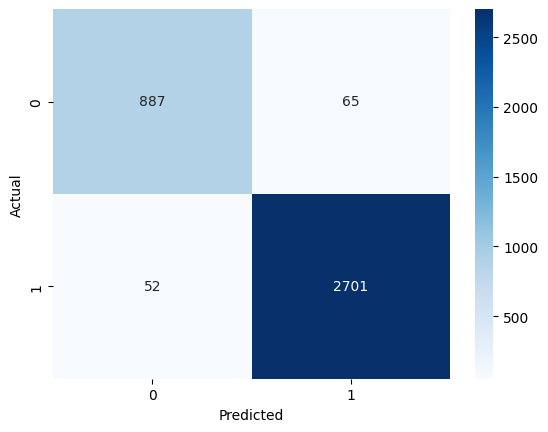

In [84]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob[:,1])
plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# XGBoost Model

In [85]:
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)


xgb.fit(X_train_clean, y_train_clean)
print("XGBoost trained successfully!")

XGBoost trained successfully!


Validation & Metrics

In [86]:
y_val_pred_xgb = xgb.predict(X_val)
y_val_prob_xgb = xgb.predict_proba(X_val)

accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
precision_xgb = precision_score(y_val, y_val_pred_xgb)
recall_xgb = recall_score(y_val, y_val_pred_xgb)
f1_xgb = f1_score(y_val, y_val_pred_xgb)
logloss_xgb = log_loss(y_val, y_val_prob_xgb)
auc_xgb = roc_auc_score(y_val, y_val_prob_xgb[:,1])

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"Log Loss: {logloss_xgb:.4f}")
print(f"AUC: {auc_xgb:.4f}")
print(f"Random Forest AUC: {auc:.4f}")
print(f"XGBoost AUC: {auc_xgb:.4f}")
cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
print("XGBoost Confusion Matrix:\n", cm_xgb)

Accuracy: 0.9673
Precision: 0.9747
Recall: 0.9815
F1 Score: 0.9781
Log Loss: 0.1446
AUC: 0.9657
Random Forest AUC: 0.9664
XGBoost AUC: 0.9657
XGBoost Confusion Matrix:
 [[ 882   70]
 [  51 2702]]


XGBoost Confusion Matrix:

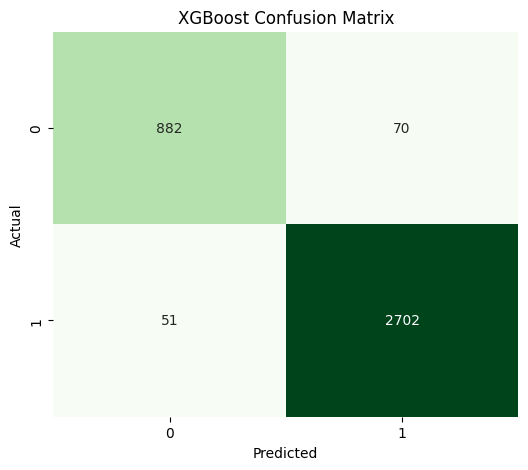

In [87]:
plt.figure(figsize=(6,5))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

ROC Curve

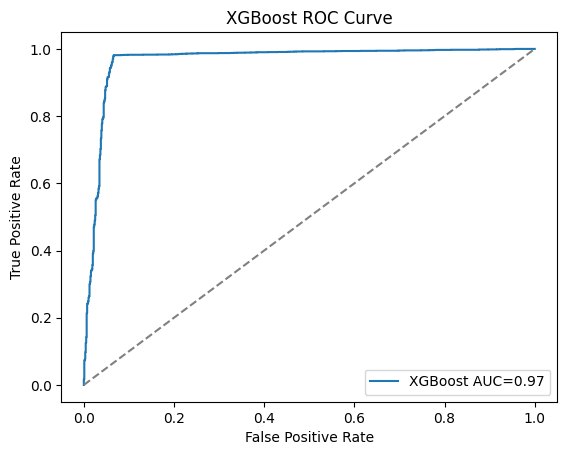

In [88]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_val, y_val_prob_xgb[:,1])
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost AUC={auc_xgb:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.show()


---

Test Prediction and Submission

In [89]:
# # Predict test
# y_test_pred = rf.predict(df2.drop(['id'], axis=1))

# # 0/1 → Introvert/Extrovert
# y_test_label = ['Introvert' if i==0 else 'Extrovert' for i in y_test_pred]


# submission = pd.DataFrame({
#     'id': df2['id'],
#     'Personality': y_test_label
# })

# # Save CSV
# submission.to_csv('submission.csv', index=False)
# print("Submission CSV is ready!")

In [ ]:
# df_sample=pd.read_csv("sample_submission.csv")
# df_sample.head()

,id,Personality
0,18524,Extrovert
1,18525,Extrovert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Extrovert


In [ ]:
# # Full sample CSV
# df_sample = pd.read_csv("sample_submission.csv")

# # Full prediction CSV
# submission = pd.read_csv("submission.csv")

# # Compare IDs and Personality columns
# df_diff = pd.merge(df_sample, submission, on='id', how='outer', suffixes=('_sample', '_pred'))

# # Filter rows where Personality predictions differ
# df_mismatch = df_diff[df_diff['Personality_sample'] != df_diff['Personality_pred']]

# # Number of mismatched rows
# print("Number of mismatches:", len(df_mismatch))

# # View first few mismatches
# print(df_mismatch.head(20))


Number of mismatches: 1561
       id Personality_sample Personality_pred
1   18525          Extrovert        Introvert
4   18528          Extrovert        Introvert
7   18531          Extrovert        Introvert
9   18533          Extrovert        Introvert
12  18536          Extrovert        Introvert
14  18538          Extrovert        Introvert
18  18542          Extrovert        Introvert
20  18544          Extrovert        Introvert
21  18545          Extrovert        Introvert
23  18547          Extrovert        Introvert
28  18552          Extrovert        Introvert
29  18553          Extrovert        Introvert
32  18556          Extrovert        Introvert
40  18564          Extrovert        Introvert
41  18565          Extrovert        Introvert
42  18566          Extrovert        Introvert
43  18567          Extrovert        Introvert
45  18569          Extrovert        Introvert
47  18571          Extrovert        Introvert
50  18574          Extrovert        Introvert


---